## LSTM Model Development

#### Introduction to LSTM
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) that are well-suited for sequence prediction problems. They are capable of learning long-term dependencies, making them particularly useful for time series forecasting tasks.

#### Data Preprocessing
The data preprocessing step involves encoding categorical features using `LabelEncoder`. This ensures that the categorical variables are converted into numerical labels, which are required for the LSTM model.


In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import STL

def preprocess_data(data):
    # Encode categorical features
    label_encoders = {}
    categorical_columns = ['StockCode', 'Description', 'Country']
    
    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
    
    return data, label_encoders

#### Data Splitting and Scaling
The dataset is split into training and testing sets using an 80-20 ratio. The features are separated from the target variable `TotalPrice`. Both the features and target variable are then scaled using `MinMaxScaler` to bring all values into the range [0, 1]. The scaled data is reshaped to fit the input requirements of the LSTM model.


In [63]:
def split_and_scale_data(data):
    # Define your features and target variable
    X = data.drop(['TotalPrice', 'InvoiceDate'], axis=1)
    y = data['TotalPrice']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

    # Reshape input to be 3D [samples, timesteps, features] for LSTM
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_test, y_scaler

#### Building the LSTM Model
The `build_lstm_model` function constructs an LSTM model using the Keras Sequential API. The model consists of two LSTM layers, each with 50 units, followed by a Dense layer with a single neuron to predict the target variable. The model is compiled using the Adam optimizer and Mean Squared Error loss function.


In [64]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))  
    model.add(LSTM(50)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

#### Training the LSTM Model
The `train_lstm_model` function trains the LSTM model on the training data. Early stopping is used to monitor the validation loss and stop training if there is no improvement for 10 epochs. This helps in preventing overfitting. The function also prints the chosen hyperparameters and learning information.


In [65]:
def train_lstm_model(X_train, y_train, X_test, y_test):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)  
    
    # Print hyperparameters and learning info
    print("Chosen Hyperparameters and Training Information:")
    print(f"Input Shape: {X_train.shape[1:]}")
    print(f"Number of LSTM Layers: 2")
    print(f"Number of Units in each LSTM Layer: 50")  
    print(f"Optimizer: Adam")
    print(f"Loss Function: Mean Squared Error")
    print(f"Batch Size: 32")
    print(f"Epochs: {len(history.history['loss'])}")
    
    return model, history

#### Plotting Learning Curves
The `plot_learning_curves` function visualizes the training and validation loss over the epochs to provide insights into the model's learning process.


In [66]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('LSTM Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Model Validation
The `validate_model` function evaluates the model's performance on the test set. It calculates several performance metrics including MAE, RMSE, MASE, and WMAPE. The scaled predictions are inverse-transformed to obtain the actual values.


In [67]:
def validate_model(model, X_test, y_test, y_scaler):
    predictions_scaled = model.predict(X_test)
    predictions = y_scaler.inverse_transform(predictions_scaled)
    y_test_actual = y_scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_actual, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    mase = mae / np.mean(np.abs(np.diff(y_test_actual.flatten())))
    wmape = np.sum(np.abs(predictions - y_test_actual)) / np.sum(y_test_actual)

    metrics = {
        'MAE (Total)': mae,
        'RMSE (Total)': rmse,
        'MASE (Total)': mase,
        'WMAPE (Total)': wmape
    }
    
    # Print validation metrics
    print("Validation Metrics:")
    for metric, value in metrics.items():
        print(f'{metric}: {value}')
    
    return metrics, predictions, y_test_actual


#### Diagnostic Check
The `diagnostic_check` function plots the true values against the predictions to visually inspect the model's performance.


In [68]:
def diagnostic_check(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.flatten(), label='True Values')
    plt.plot(predictions.flatten(), label='Predictions')
    plt.title('LSTM Model - True vs Predictions')
    plt.xlabel('Time')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Seasonal Decomposition
The `decompose_seasonal_component` function decomposes the seasonal component of the time series data using STL decomposition.


In [69]:
def decompose_seasonal_component(data):
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    data.set_index('InvoiceDate', inplace=True)
    daily_sales = data['TotalPrice'].resample('D').sum().fillna(0)
    stl = STL(daily_sales, seasonal=7)
    result = stl.fit()
    return result

#### Calculate Seasonal Metrics
The `calculate_seasonal_metrics` function calculates the seasonal MAE and RMSE for the model's predictions.


In [70]:
def calculate_seasonal_metrics(model, X_test, y_test, seasonal_component):
    predictions_scaled = model.predict(X_test)
    predictions = y_test.flatten()

    # Ensure the lengths match
    if len(predictions) < len(seasonal_component):
        seasonal_component = seasonal_component[-len(predictions):]
    else:
        predictions = predictions[-len(seasonal_component):]

    smae = mean_absolute_error(seasonal_component, predictions)
    srmse = np.sqrt(mean_squared_error(seasonal_component, predictions))

    seasonal_metrics = {
        'MAE (Seasonal)': smae,
        'RMSE (Seasonal)': srmse
    }

    return seasonal_metrics

#### Plot Seasonal Comparisons
The `plot_seasonal_comparisons` function plots the true seasonal component against the model's predicted seasonal component.


In [71]:
def plot_seasonal_comparisons(y_test, predictions, seasonal_component):
    # Ensure the lengths match
    if len(predictions) < len(seasonal_component):
        seasonal_component = seasonal_component[-len(predictions):]
    else:
        predictions = predictions[-len(seasonal_component):]

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(seasonal_component)), seasonal_component, label='True Seasonal')
    plt.plot(range(len(predictions)), predictions, label='Predicted Seasonal')
    plt.title('True vs Predicted Seasonal Components')
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Plot Seasonal Decomposition
The `plot_seasonal_decomposition` function plots the components of the STL decomposition.


In [72]:
def plot_seasonal_decomposition(stl_result):
    stl_result.plot()
    plt.show()

#### Main Function
The `main_lstm` function orchestrates the data preprocessing, model training, validation, and seasonal analysis. It also logs the chosen hyperparameters and the calculated performance metrics.


Epoch 1/100
19488/19488 - 16s - loss: 2.0358e-06 - val_loss: 1.6809e-06 - 16s/epoch - 843us/step
Epoch 2/100
19488/19488 - 15s - loss: 1.9309e-06 - val_loss: 1.4489e-06 - 15s/epoch - 786us/step
Epoch 3/100
19488/19488 - 16s - loss: 1.9130e-06 - val_loss: 1.3010e-06 - 16s/epoch - 809us/step
Epoch 4/100
19488/19488 - 15s - loss: 1.7795e-06 - val_loss: 1.2638e-06 - 15s/epoch - 788us/step
Epoch 5/100
19488/19488 - 15s - loss: 1.7343e-06 - val_loss: 9.1809e-07 - 15s/epoch - 795us/step
Epoch 6/100
19488/19488 - 15s - loss: 1.6851e-06 - val_loss: 1.0469e-06 - 15s/epoch - 791us/step
Epoch 7/100
19488/19488 - 16s - loss: 1.6326e-06 - val_loss: 7.7496e-07 - 16s/epoch - 795us/step
Epoch 8/100
19488/19488 - 15s - loss: 1.5509e-06 - val_loss: 5.8255e-07 - 15s/epoch - 792us/step
Epoch 9/100
19488/19488 - 15s - loss: 1.4531e-06 - val_loss: 7.6176e-07 - 15s/epoch - 793us/step
Epoch 10/100
19488/19488 - 15s - loss: 1.3319e-06 - val_loss: 5.1559e-07 - 15s/epoch - 794us/step
Epoch 11/100
19488/19488 - 15

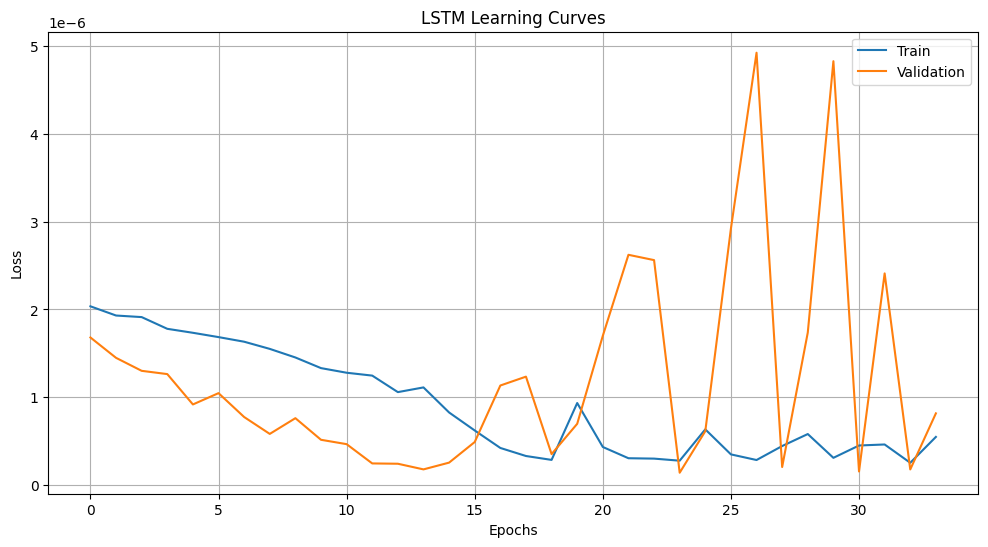

4872/4872 [==============================] - 2s 301us/step
Validation Metrics:
MAE (Total): 17.72012460286614
RMSE (Total): 63.146005282387314
MASE (Total): 0.6286100738966163
WMAPE (Total): 0.7914887928019223


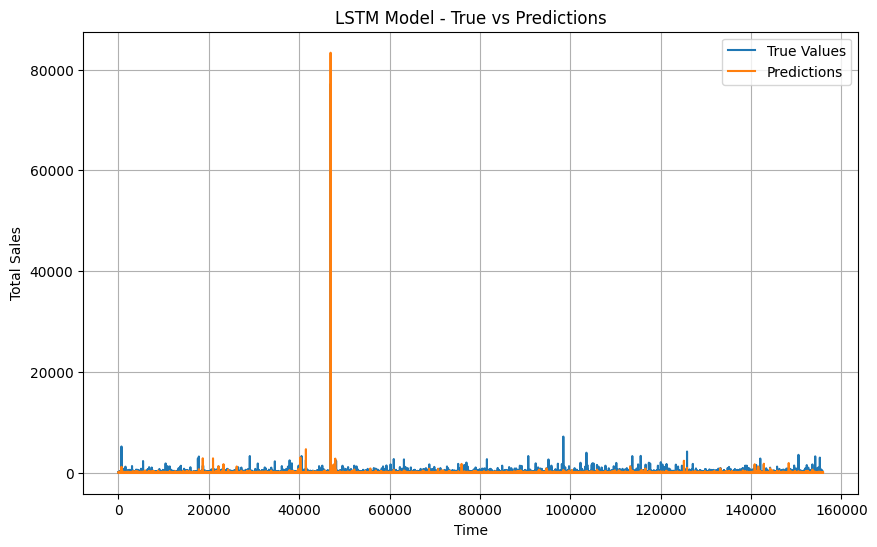

4872/4872 [==============================] - 2s 307us/step
Seasonal Metrics: {'MAE (Seasonal)': 9156.349258015809, 'RMSE (Seasonal)': 12458.843139013801}


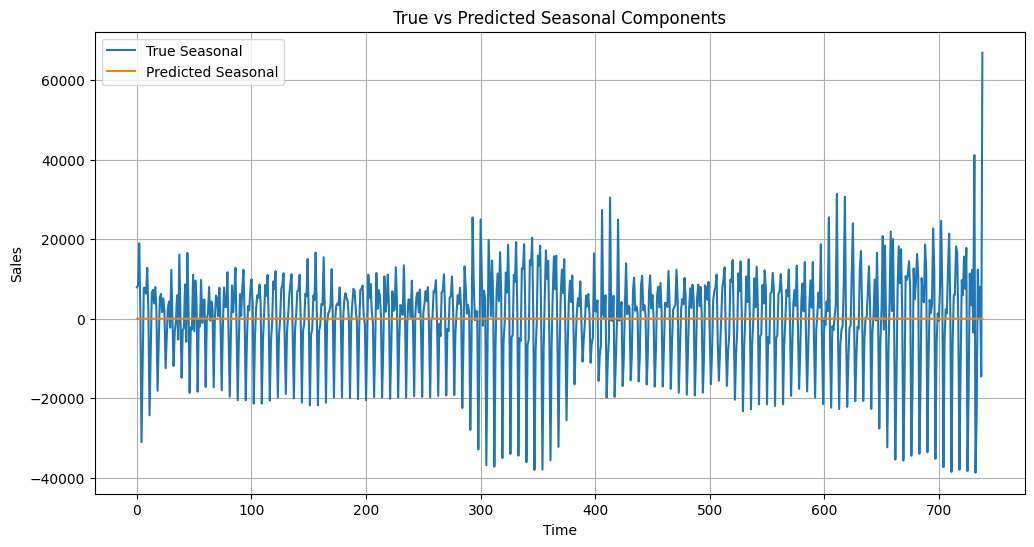

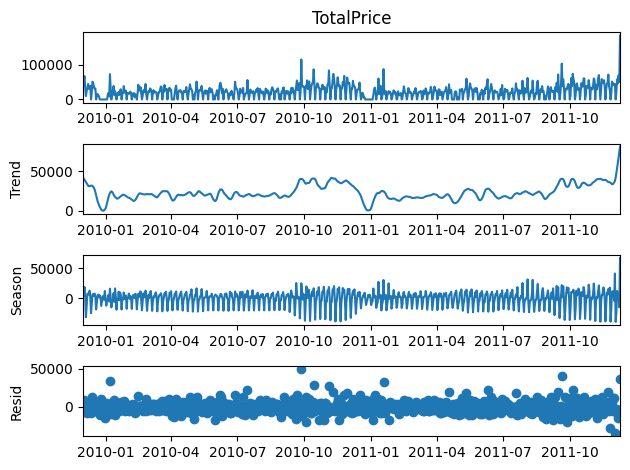

Model performance metrics updated and saved to model_performance_metrics.csv


/var/folders/x3/h0qgc64j0gs_982j8_34cq540000gp/T/ipykernel_7078/3153469675.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [73]:
def main_lstm(file_path, metrics_df_path):
    data = pd.read_csv(file_path)
    data, label_encoders = preprocess_data(data)
    X_train, X_test, y_train, y_test, y_test_actual, y_scaler = split_and_scale_data(data)

    stl_result = decompose_seasonal_component(data)
    seasonal_component = stl_result.seasonal

    model, history = train_lstm_model(X_train, y_train, X_test, y_test)
    plot_learning_curves(history)
    metrics, predictions, y_test_actual = validate_model(model, X_test, y_test, y_scaler)
    diagnostic_check(y_test_actual, predictions)

    seasonal_metrics = calculate_seasonal_metrics(model, X_test, y_test_actual, seasonal_component)
    print(f'Seasonal Metrics: {seasonal_metrics}')
    plot_seasonal_comparisons(y_test_actual, predictions, seasonal_component)
    plot_seasonal_decomposition(stl_result)

    # Load or create a metrics DataFrame
    try:
        metrics_df = pd.read_csv(metrics_df_path)
    except FileNotFoundError:
        metrics_df = pd.DataFrame(columns=['Model', 'MAE (Total)', 'RMSE (Total)', 'MASE (Total)', 'WMAPE (Total)', 'MAE (Seasonal)', 'RMSE (Seasonal)'])

    metrics['Model'] = 'LSTM'
    metrics.update(seasonal_metrics)
    metrics_df = metrics_df.append(metrics, ignore_index=True)

    # Save the updated metrics DataFrame
    metrics_df.to_csv(metrics_df_path, index=False)
    print('Model performance metrics updated and saved to', metrics_df_path)

file_path = 'preprocessed_data.csv'
metrics_df_path = 'model_performance_metrics.csv'
main_lstm(file_path, metrics_df_path)